In [2]:
import os
import re
import math
import time
import torch

import librosa
import librosa.display
import itertools
import functools
import torchaudio
import torchvision
import torch.optim


import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F
from torch.utils.data import DataLoader

import IPython.display as ipd

from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch import nn, einsum
from inspect import isfunction



import torchaudio.transforms as T

import IPython.display as ipd
import sentencepiece as spm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


import torch.utils.data
from librosa.util import normalize
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn

import pickle
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel

MAX_WAV_VALUE = 32768.0


import lib
import tqdm
from torchvision.utils import make_grid

from tqdm import tqdm



In [3]:
is_cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda:0


In [7]:
cd ../

/data/code/kmkim


In [8]:
from hifi_gan import Generator as hifigan_vocoder
from omegaconf import OmegaConf

path_config = 'hifi_gan.json'
path_ckpt = 'g_02500000'

hifigan_config = OmegaConf.load(path_config)
vocoder = hifigan_vocoder(hifigan_config)

state_dict_g = torch.load(path_ckpt)
vocoder = vocoder.to(device)
vocoder.load_state_dict(state_dict_g['generator'])
vocoder.eval()

Generator(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (resblocks): ModuleList(
    (0): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride

In [9]:
    
def inference_to_audio(x, sr = 22050, n_mels = 80):
    
    inference_ = (x.cpu() - 1) * 80.0

    S = librosa.db_to_power(inference_)

    zxc = spectral_normalize_torch(S.squeeze()) ## 나온 power 정규화 필수
    
    conv_wav = vocoder(zxc.to(device)) 
    
    conv_wav = conv_wav.squeeze().detach().cpu().numpy()
    
    print(librosa.display.waveshow(conv_wav))
    
    return conv_wav

In [10]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)
    # return torch.clamp(x, min=clip_val) * C


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output


sr = 22050
n_fft = 1024
win_length = n_fft
hop_length = 256

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft=n_fft, num_mels=80, sampling_rate= sr, hop_size=hop_length, win_size=win_length, fmin=0, fmax=8000, center=False):
    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax) + '_' + str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)
    
    #print(y.shape) # 45237, 1 (1024-256)/2, (1024-256)/2
    y = torch.nn.functional.pad(y.unsqueeze(0), ((int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2))),
                                mode='reflect')
    y = y.squeeze(1)
    
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex = False) # return_complex =False

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9)) #???

    spec = torch.matmul(mel_basis[str(fmax) + '_' + str(y.device)], spec)
        
    spec = librosa.power_to_db(spec, ref=np.max, top_db = num_mels) ## dB 단위로 변형 numpy로 결과가 나옴
    

    spec = (spec / 80.0) + 1

    
    return torch.from_numpy(spec.astype("float32")) ## numpy를 torch로

In [11]:
def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [12]:


cemblayer = lib.ConditionalEmbedding(10, 10, 10).to(device)

In [13]:
import torchvision.transforms as T

batch_size = 32

train_ds = lib.AudioDataset('./diffusion_speech_enhancement/guided_speech_diffusion/data/', label_transform=T.ToTensor())

data_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    collate_fn = lib.collate_fn,
    num_workers = 8,
    shuffle=True,
    pin_memory = True,
    drop_last = True
)


In [14]:
import lib
model = lib.CF_Unet(
    dim=56,
    channels=1,
    init_dim = 32,
    cdim = 10,
    dim_mults=(1, 2, 2, 4),
    resnet_block_groups = 32,
)

model.to(device)

optimizer = torch.optim.AdamW(itertools.chain(model.parameters(), cemblayer.parameters()), lr=5e-4)

In [15]:
def p_losses(denoise_model, x_start, t, cemb, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, cemb)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [16]:
def loss_fn(model, x, marginal_prob_std, cemb, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t, cemb)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [28]:
from torchvision.utils import save_image
from tqdm import tqdm
epochs = 600
before_loss = 999999.0
saved_epoch = 0

threshold = 0.2

for epoch in range(epochs):
    
    total_loss = 0

    for step, batch in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()

        batch_size = batch[0].shape[0]
        image = batch[0].to(device)
        label = batch[1].to(device)
        
        cemb = cemblayer(label)
        
        # threshold 미만인 부분은 unconditional 한 방식으로 학습
        cemb[np.where(np.random.rand(batch_size)< threshold)] = 0

       # Algorithm 1 line 3: sample t uniformally for every example in the batch
        #t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = loss_fn(model, image, marginal_prob_std_fn, cemb)
        
        total_loss += loss

        loss.backward()
        optimizer.step()

        
    total_loss = total_loss / len(data_loader)
    print(f"epoch : {epoch} Loss : {total_loss} ")
    
    if before_loss > total_loss:
            saved_epoch = epoch
            print(f"before_loss = {before_loss:.4f}, loss = {total_loss:.4f}, saved_epoch = {saved_epoch}" )
            print('model_save')
            torch.save(cemblayer.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_Guide_embedding_layer.pth')
            torch.save(model.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_Guided.pth')
            before_loss = total_loss



  0%|                                                   | 0/937 [00:00<?, ?it/s]/tmp/ipykernel_1556452/2894061068.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
100%|█████████████████████████████████████████| 937/937 [01:37<00:00,  9.64it/s]


epoch : 0 Loss : 713.4583740234375 
before_loss = 999999.0000, loss = 713.4584, saved_epoch = 0
model_save


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 1 Loss : 130.3097381591797 
before_loss = 713.4584, loss = 130.3097, saved_epoch = 1
model_save


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 2 Loss : 128.90438842773438 
before_loss = 130.3097, loss = 128.9044, saved_epoch = 2
model_save


100%|█████████████████████████████████████████| 937/937 [01:40<00:00,  9.31it/s]


epoch : 3 Loss : 102.23424530029297 
before_loss = 128.9044, loss = 102.2342, saved_epoch = 3
model_save


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.26it/s]


epoch : 4 Loss : 57.696964263916016 
before_loss = 102.2342, loss = 57.6970, saved_epoch = 4
model_save


100%|█████████████████████████████████████████| 937/937 [01:40<00:00,  9.30it/s]


epoch : 5 Loss : 123.6903305053711 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.19it/s]


epoch : 6 Loss : 64.52717590332031 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 7 Loss : 46.356388092041016 
before_loss = 57.6970, loss = 46.3564, saved_epoch = 7
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 8 Loss : 73.21258544921875 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 9 Loss : 40.136131286621094 
before_loss = 46.3564, loss = 40.1361, saved_epoch = 9
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 10 Loss : 58.968353271484375 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.84it/s]


epoch : 11 Loss : 43.031166076660156 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 12 Loss : 31.889192581176758 
before_loss = 40.1361, loss = 31.8892, saved_epoch = 12
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 13 Loss : 53.08932113647461 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 14 Loss : 42.52814865112305 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 15 Loss : 47.57037353515625 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 16 Loss : 28.665210723876953 
before_loss = 31.8892, loss = 28.6652, saved_epoch = 16
model_save


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 17 Loss : 30.759838104248047 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 18 Loss : 29.884376525878906 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 19 Loss : 28.588220596313477 
before_loss = 28.6652, loss = 28.5882, saved_epoch = 19
model_save


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 20 Loss : 29.80550193786621 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 21 Loss : 40.0292854309082 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 22 Loss : 45.170387268066406 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 23 Loss : 26.9453182220459 
before_loss = 28.5882, loss = 26.9453, saved_epoch = 23
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 24 Loss : 26.2386417388916 
before_loss = 26.9453, loss = 26.2386, saved_epoch = 24
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 25 Loss : 25.602190017700195 
before_loss = 26.2386, loss = 25.6022, saved_epoch = 25
model_save


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 26 Loss : 25.114524841308594 
before_loss = 25.6022, loss = 25.1145, saved_epoch = 26
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 27 Loss : 35.04175567626953 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 28 Loss : 26.857948303222656 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 29 Loss : 24.47201919555664 
before_loss = 25.1145, loss = 24.4720, saved_epoch = 29
model_save


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.01it/s]


epoch : 30 Loss : 25.162363052368164 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 31 Loss : 23.386381149291992 
before_loss = 24.4720, loss = 23.3864, saved_epoch = 31
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 32 Loss : 24.14159393310547 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 33 Loss : 24.312541961669922 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 34 Loss : 24.283397674560547 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 35 Loss : 23.685443878173828 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 36 Loss : 28.977304458618164 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 37 Loss : 27.840938568115234 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 38 Loss : 24.652572631835938 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 39 Loss : 22.113754272460938 
before_loss = 23.3864, loss = 22.1138, saved_epoch = 39
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 40 Loss : 22.214033126831055 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 41 Loss : 23.266815185546875 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 42 Loss : 21.753040313720703 
before_loss = 22.1138, loss = 21.7530, saved_epoch = 42
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 43 Loss : 22.318288803100586 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 44 Loss : 45.198692321777344 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 45 Loss : 22.733091354370117 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 46 Loss : 21.77787208557129 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 47 Loss : 21.59054183959961 
before_loss = 21.7530, loss = 21.5905, saved_epoch = 47
model_save


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 48 Loss : 21.844247817993164 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 49 Loss : 21.08514404296875 
before_loss = 21.5905, loss = 21.0851, saved_epoch = 49
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 50 Loss : 20.859464645385742 
before_loss = 21.0851, loss = 20.8595, saved_epoch = 50
model_save


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 51 Loss : 34.02927780151367 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 52 Loss : 21.6550235748291 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 53 Loss : 21.569122314453125 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 54 Loss : 21.4857120513916 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 55 Loss : 21.672468185424805 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 56 Loss : 21.3800106048584 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 57 Loss : 20.733640670776367 
before_loss = 20.8595, loss = 20.7336, saved_epoch = 57
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 58 Loss : 21.16469383239746 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 59 Loss : 20.4544677734375 
before_loss = 20.7336, loss = 20.4545, saved_epoch = 59
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 60 Loss : 30.468833923339844 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 61 Loss : 21.910125732421875 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.53it/s]


epoch : 62 Loss : 20.683446884155273 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 63 Loss : 20.88414764404297 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 64 Loss : 21.28934669494629 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 65 Loss : 20.553691864013672 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 66 Loss : 20.145313262939453 
before_loss = 20.4545, loss = 20.1453, saved_epoch = 66
model_save


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 67 Loss : 19.910602569580078 
before_loss = 20.1453, loss = 19.9106, saved_epoch = 67
model_save


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 68 Loss : 32.262413024902344 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 69 Loss : 19.1771240234375 
before_loss = 19.9106, loss = 19.1771, saved_epoch = 69
model_save


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 70 Loss : 20.617887496948242 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 71 Loss : 20.108806610107422 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 72 Loss : 18.869646072387695 
before_loss = 19.1771, loss = 18.8696, saved_epoch = 72
model_save


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.98it/s]


epoch : 73 Loss : 20.870779037475586 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 74 Loss : 19.34052085876465 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 75 Loss : 19.807390213012695 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 76 Loss : 19.802536010742188 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 77 Loss : 20.75693702697754 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 78 Loss : 19.573307037353516 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 79 Loss : 19.443628311157227 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 80 Loss : 19.643348693847656 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 81 Loss : 19.175586700439453 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 82 Loss : 18.976011276245117 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 83 Loss : 20.566558837890625 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 84 Loss : 19.655452728271484 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 85 Loss : 52.44232940673828 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.25it/s]


epoch : 86 Loss : 25.1998291015625 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 87 Loss : 20.509811401367188 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 88 Loss : 20.83037757873535 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 89 Loss : 19.928510665893555 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 90 Loss : 18.859634399414062 
before_loss = 18.8696, loss = 18.8596, saved_epoch = 90
model_save


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 91 Loss : 20.435134887695312 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 92 Loss : 18.986263275146484 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 93 Loss : 19.038545608520508 


100%|█████████████████████████████████████████| 937/937 [01:40<00:00,  9.28it/s]


epoch : 94 Loss : 19.62745475769043 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 95 Loss : 29.64150047302246 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 96 Loss : 19.500469207763672 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 97 Loss : 19.37566566467285 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 98 Loss : 19.278427124023438 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 99 Loss : 19.751544952392578 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 100 Loss : 20.055686950683594 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 101 Loss : 18.74850845336914 
before_loss = 18.8596, loss = 18.7485, saved_epoch = 101
model_save


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 102 Loss : 18.819068908691406 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 103 Loss : 19.293004989624023 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 104 Loss : 29.15974998474121 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 105 Loss : 19.793012619018555 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 106 Loss : 19.715599060058594 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 107 Loss : 19.229393005371094 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 108 Loss : 19.146137237548828 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 109 Loss : 20.126680374145508 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 110 Loss : 19.327016830444336 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 111 Loss : 18.988264083862305 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 112 Loss : 23.08840560913086 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 113 Loss : 18.206445693969727 
before_loss = 18.7485, loss = 18.2064, saved_epoch = 113
model_save


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 114 Loss : 18.95791244506836 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 115 Loss : 19.271728515625 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 116 Loss : 18.516130447387695 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 117 Loss : 29.521764755249023 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 118 Loss : 19.410322189331055 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 119 Loss : 19.113384246826172 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 120 Loss : 18.941360473632812 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 121 Loss : 20.479368209838867 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 122 Loss : 18.81820297241211 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 123 Loss : 18.26188087463379 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 124 Loss : 18.82113265991211 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 125 Loss : 18.736669540405273 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 126 Loss : 18.334980010986328 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.25it/s]


epoch : 127 Loss : 38.80116653442383 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 128 Loss : 18.513092041015625 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.28it/s]


epoch : 129 Loss : 17.616657257080078 
before_loss = 18.2064, loss = 17.6167, saved_epoch = 129
model_save


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 130 Loss : 18.258953094482422 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 131 Loss : 18.671945571899414 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.26it/s]


epoch : 132 Loss : 18.135719299316406 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 133 Loss : 18.870193481445312 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.26it/s]


epoch : 134 Loss : 17.627029418945312 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 135 Loss : 18.382173538208008 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 136 Loss : 18.346519470214844 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 137 Loss : 18.262897491455078 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 138 Loss : 18.121810913085938 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 139 Loss : 17.640575408935547 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 140 Loss : 18.58066749572754 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 141 Loss : 18.66260528564453 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.27it/s]


epoch : 142 Loss : 18.547605514526367 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 143 Loss : 17.44152069091797 
before_loss = 17.6167, loss = 17.4415, saved_epoch = 143
model_save


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 144 Loss : 18.874731063842773 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 145 Loss : 18.780630111694336 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 146 Loss : 18.63235855102539 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 147 Loss : 19.4512939453125 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 148 Loss : 17.696455001831055 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 149 Loss : 18.453269958496094 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 150 Loss : 17.347030639648438 
before_loss = 17.4415, loss = 17.3470, saved_epoch = 150
model_save


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.26it/s]


epoch : 151 Loss : 18.41736602783203 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 152 Loss : 18.23472023010254 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 153 Loss : 18.158992767333984 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 154 Loss : 28.321002960205078 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.26it/s]


epoch : 155 Loss : 18.953794479370117 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 156 Loss : 18.194271087646484 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 157 Loss : 17.841333389282227 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 158 Loss : 17.822538375854492 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 159 Loss : 18.474754333496094 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 160 Loss : 17.961191177368164 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 161 Loss : 17.729232788085938 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 162 Loss : 23.944473266601562 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 163 Loss : 17.82406997680664 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.27it/s]


epoch : 164 Loss : 17.775388717651367 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 165 Loss : 18.0002384185791 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 166 Loss : 17.849618911743164 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 167 Loss : 18.10349464416504 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 168 Loss : 17.6396427154541 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 169 Loss : 18.00296401977539 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 170 Loss : 18.681602478027344 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 171 Loss : 18.03745460510254 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 172 Loss : 18.361064910888672 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 173 Loss : 17.830751419067383 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 174 Loss : 17.829357147216797 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 175 Loss : 17.974506378173828 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 176 Loss : 18.089618682861328 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.24it/s]


epoch : 177 Loss : 18.153182983398438 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 178 Loss : 23.999879837036133 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 179 Loss : 18.300413131713867 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 180 Loss : 17.68060874938965 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 181 Loss : 17.777666091918945 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.22it/s]


epoch : 182 Loss : 17.781421661376953 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 183 Loss : 18.39644432067871 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 184 Loss : 17.619457244873047 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.94it/s]


epoch : 185 Loss : 17.535282135009766 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 186 Loss : 18.466384887695312 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 187 Loss : 18.060901641845703 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 188 Loss : 17.737709045410156 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 189 Loss : 17.06998062133789 
before_loss = 17.3470, loss = 17.0700, saved_epoch = 189
model_save


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 190 Loss : 17.281660079956055 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 191 Loss : 17.52147102355957 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 192 Loss : 18.334077835083008 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.01it/s]


epoch : 193 Loss : 17.692523956298828 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 194 Loss : 17.73520851135254 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 195 Loss : 17.913169860839844 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 196 Loss : 17.20606803894043 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 197 Loss : 17.35961151123047 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 198 Loss : 17.33099937438965 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 199 Loss : 17.81101417541504 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 200 Loss : 17.632490158081055 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 201 Loss : 18.112180709838867 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 202 Loss : 17.36508560180664 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 203 Loss : 17.13510513305664 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 204 Loss : 17.568220138549805 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 205 Loss : 17.448814392089844 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 206 Loss : 18.316987991333008 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 207 Loss : 18.02448081970215 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 208 Loss : 17.984966278076172 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 209 Loss : 17.32306480407715 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 210 Loss : 17.790861129760742 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 211 Loss : 17.818010330200195 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 212 Loss : 17.16922378540039 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 213 Loss : 17.450456619262695 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 214 Loss : 17.51751708984375 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 215 Loss : 17.679758071899414 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 216 Loss : 17.93060302734375 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 217 Loss : 17.981721878051758 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 218 Loss : 17.0878963470459 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 219 Loss : 17.02851676940918 
before_loss = 17.0700, loss = 17.0285, saved_epoch = 219
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 220 Loss : 17.395519256591797 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


epoch : 221 Loss : 17.605432510375977 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 222 Loss : 17.625802993774414 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 223 Loss : 16.59807777404785 
before_loss = 17.0285, loss = 16.5981, saved_epoch = 223
model_save


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 224 Loss : 18.04629898071289 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 225 Loss : 17.030712127685547 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 226 Loss : 21.893651962280273 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 227 Loss : 17.565750122070312 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 228 Loss : 17.61324119567871 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 229 Loss : 17.728906631469727 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 230 Loss : 18.029930114746094 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 231 Loss : 16.30765724182129 
before_loss = 16.5981, loss = 16.3077, saved_epoch = 231
model_save


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 232 Loss : 16.664709091186523 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 233 Loss : 17.638263702392578 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 234 Loss : 17.6994571685791 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 235 Loss : 16.742128372192383 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 236 Loss : 18.265422821044922 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


epoch : 237 Loss : 17.294315338134766 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 238 Loss : 17.73671531677246 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 239 Loss : 17.395360946655273 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 240 Loss : 17.571331024169922 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.96it/s]


epoch : 241 Loss : 18.12240982055664 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 242 Loss : 17.58015251159668 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 243 Loss : 17.391714096069336 


100%|█████████████████████████████████████████| 937/937 [01:51<00:00,  8.42it/s]


epoch : 244 Loss : 17.361915588378906 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 245 Loss : 17.055034637451172 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 246 Loss : 17.24681282043457 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.94it/s]


epoch : 247 Loss : 17.506107330322266 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 248 Loss : 17.222558975219727 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 249 Loss : 17.72998809814453 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 250 Loss : 17.303028106689453 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 251 Loss : 16.941238403320312 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 252 Loss : 17.252145767211914 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 253 Loss : 17.74139404296875 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 254 Loss : 16.99083709716797 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 255 Loss : 17.455080032348633 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 256 Loss : 17.404882431030273 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 257 Loss : 17.84972381591797 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 258 Loss : 17.410314559936523 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 259 Loss : 16.9641056060791 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 260 Loss : 17.242813110351562 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 261 Loss : 16.83465576171875 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 262 Loss : 16.883888244628906 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 263 Loss : 17.192066192626953 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 264 Loss : 17.764835357666016 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 265 Loss : 24.747602462768555 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 266 Loss : 18.17658805847168 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 267 Loss : 16.997772216796875 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 268 Loss : 16.415494918823242 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 269 Loss : 19.91853904724121 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 270 Loss : 17.404035568237305 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 271 Loss : 17.1483211517334 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 272 Loss : 17.38631248474121 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 273 Loss : 17.292261123657227 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 274 Loss : 17.47329330444336 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.94it/s]


epoch : 275 Loss : 17.609237670898438 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 276 Loss : 17.43733024597168 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 277 Loss : 17.22333526611328 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 278 Loss : 17.52836799621582 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 279 Loss : 17.149009704589844 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 280 Loss : 16.920907974243164 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 281 Loss : 16.812793731689453 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 282 Loss : 16.73040199279785 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 283 Loss : 23.918249130249023 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 284 Loss : 17.457422256469727 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 285 Loss : 17.45713996887207 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 286 Loss : 17.27841567993164 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 287 Loss : 16.9277286529541 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 288 Loss : 17.45337677001953 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 289 Loss : 17.551578521728516 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.98it/s]


epoch : 290 Loss : 16.78471565246582 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 291 Loss : 16.338279724121094 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.96it/s]


epoch : 292 Loss : 16.661773681640625 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 293 Loss : 17.222270965576172 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 294 Loss : 17.369503021240234 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 295 Loss : 17.19091796875 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 296 Loss : 17.04503631591797 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 297 Loss : 16.4881591796875 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 298 Loss : 17.37830924987793 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 299 Loss : 17.111629486083984 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 300 Loss : 17.525035858154297 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.56it/s]


epoch : 301 Loss : 20.370718002319336 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.44it/s]


epoch : 302 Loss : 17.12055206298828 


100%|█████████████████████████████████████████| 937/937 [01:51<00:00,  8.39it/s]


epoch : 303 Loss : 17.494169235229492 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 304 Loss : 17.4717960357666 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 305 Loss : 17.544178009033203 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 306 Loss : 17.156248092651367 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 307 Loss : 16.696369171142578 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 308 Loss : 18.005992889404297 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 309 Loss : 17.191421508789062 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.52it/s]


epoch : 310 Loss : 17.26094627380371 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 311 Loss : 20.78728675842285 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 312 Loss : 17.10817527770996 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.10it/s]


epoch : 313 Loss : 16.40228271484375 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 314 Loss : 17.078739166259766 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 315 Loss : 16.904447555541992 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 316 Loss : 17.89793586730957 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 317 Loss : 17.076704025268555 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 318 Loss : 17.240432739257812 


100%|█████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 319 Loss : 17.066268920898438 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 320 Loss : 16.96117401123047 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 321 Loss : 17.18421173095703 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 322 Loss : 17.924461364746094 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 323 Loss : 17.77532958984375 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 324 Loss : 16.74494743347168 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 325 Loss : 16.656953811645508 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 326 Loss : 16.478336334228516 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.52it/s]


epoch : 327 Loss : 22.00225830078125 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 328 Loss : 16.642356872558594 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.48it/s]


epoch : 329 Loss : 17.629230499267578 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 330 Loss : 17.043415069580078 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 331 Loss : 16.846500396728516 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 332 Loss : 17.417903900146484 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 333 Loss : 16.883974075317383 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 334 Loss : 16.38690185546875 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 335 Loss : 17.110647201538086 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 336 Loss : 17.039430618286133 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 337 Loss : 17.31337547302246 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 338 Loss : 17.624347686767578 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 339 Loss : 27.08868408203125 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 340 Loss : 16.750301361083984 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 341 Loss : 16.781307220458984 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 342 Loss : 17.27678108215332 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 343 Loss : 16.967493057250977 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 344 Loss : 17.238969802856445 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.94it/s]


epoch : 345 Loss : 16.93731689453125 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 346 Loss : 16.98109245300293 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 347 Loss : 17.575664520263672 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 348 Loss : 17.08755111694336 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 349 Loss : 17.66248893737793 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 350 Loss : 15.820819854736328 
before_loss = 16.3077, loss = 15.8208, saved_epoch = 350
model_save


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 351 Loss : 17.37224769592285 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.96it/s]


epoch : 352 Loss : 16.67904281616211 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 353 Loss : 17.1628475189209 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 354 Loss : 17.064340591430664 


100%|█████████████████████████████████████████| 937/937 [01:52<00:00,  8.32it/s]


epoch : 355 Loss : 20.254362106323242 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 356 Loss : 16.486967086791992 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 357 Loss : 17.474746704101562 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 358 Loss : 16.49443244934082 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 359 Loss : 16.732337951660156 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 360 Loss : 16.437576293945312 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.55it/s]


epoch : 361 Loss : 17.02147674560547 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.53it/s]


epoch : 362 Loss : 16.735368728637695 


100%|█████████████████████████████████████████| 937/937 [01:51<00:00,  8.39it/s]


epoch : 363 Loss : 17.392061233520508 


100%|█████████████████████████████████████████| 937/937 [01:52<00:00,  8.34it/s]


epoch : 364 Loss : 16.991912841796875 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 365 Loss : 17.318185806274414 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 366 Loss : 17.513303756713867 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 367 Loss : 16.98690414428711 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 368 Loss : 17.18466567993164 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 369 Loss : 17.379989624023438 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


epoch : 370 Loss : 16.775360107421875 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 371 Loss : 16.954410552978516 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 372 Loss : 16.624521255493164 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 373 Loss : 17.56279754638672 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 374 Loss : 17.26761817932129 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 375 Loss : 17.17845344543457 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 376 Loss : 16.36429786682129 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 377 Loss : 16.666748046875 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 378 Loss : 17.16610336303711 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 379 Loss : 16.591835021972656 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 380 Loss : 17.177995681762695 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.55it/s]


epoch : 381 Loss : 16.942485809326172 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.56it/s]


epoch : 382 Loss : 17.33751106262207 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 383 Loss : 16.8997745513916 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 384 Loss : 17.20131492614746 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 385 Loss : 17.008014678955078 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 386 Loss : 17.428436279296875 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 387 Loss : 17.063623428344727 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 388 Loss : 16.615142822265625 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 389 Loss : 16.53463363647461 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 390 Loss : 16.12642478942871 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 391 Loss : 16.707958221435547 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 392 Loss : 17.40985107421875 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.44it/s]


epoch : 393 Loss : 16.63469696044922 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 394 Loss : 17.315946578979492 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 395 Loss : 16.870590209960938 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 396 Loss : 21.08550262451172 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 397 Loss : 17.22049331665039 


100%|█████████████████████████████████████████| 937/937 [01:52<00:00,  8.32it/s]


epoch : 398 Loss : 16.42074203491211 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 399 Loss : 16.65406036376953 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 400 Loss : 17.234819412231445 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 401 Loss : 17.70353126525879 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 402 Loss : 16.373348236083984 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 403 Loss : 16.16665267944336 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 404 Loss : 17.005008697509766 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 405 Loss : 16.673437118530273 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 406 Loss : 16.702579498291016 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 407 Loss : 16.307613372802734 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 408 Loss : 17.158159255981445 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 409 Loss : 17.05460548400879 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 410 Loss : 16.678810119628906 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 411 Loss : 16.29073715209961 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 412 Loss : 16.678361892700195 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 413 Loss : 17.082393646240234 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 414 Loss : 16.218828201293945 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 415 Loss : 17.117992401123047 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 416 Loss : 16.263486862182617 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.45it/s]


epoch : 417 Loss : 16.94443702697754 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 418 Loss : 17.145931243896484 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 419 Loss : 19.847280502319336 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 420 Loss : 16.691587448120117 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 421 Loss : 16.433549880981445 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 422 Loss : 17.08761978149414 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 423 Loss : 17.391315460205078 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 424 Loss : 16.7481632232666 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.53it/s]


epoch : 425 Loss : 16.776546478271484 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 426 Loss : 16.870941162109375 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 427 Loss : 16.822904586791992 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 428 Loss : 16.889081954956055 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 429 Loss : 16.346681594848633 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 430 Loss : 16.9469051361084 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 431 Loss : 18.79022979736328 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 432 Loss : 16.72323989868164 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 433 Loss : 16.987483978271484 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 434 Loss : 17.070131301879883 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 435 Loss : 16.55097770690918 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 436 Loss : 17.106966018676758 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.84it/s]


epoch : 437 Loss : 16.497325897216797 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.63it/s]


epoch : 438 Loss : 16.813262939453125 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 439 Loss : 16.73967170715332 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 440 Loss : 16.48202896118164 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 441 Loss : 16.6976375579834 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 442 Loss : 16.757787704467773 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 443 Loss : 16.190698623657227 


100%|█████████████████████████████████████████| 937/937 [01:51<00:00,  8.41it/s]


epoch : 444 Loss : 17.046533584594727 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 445 Loss : 21.503074645996094 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 446 Loss : 16.369081497192383 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 447 Loss : 17.301008224487305 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 448 Loss : 16.949920654296875 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 449 Loss : 16.67353630065918 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 450 Loss : 16.846267700195312 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 451 Loss : 16.763174057006836 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 452 Loss : 16.739530563354492 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 453 Loss : 16.72422981262207 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 454 Loss : 17.63068389892578 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.76it/s]


epoch : 455 Loss : 17.117176055908203 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.01it/s]


epoch : 456 Loss : 16.694091796875 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 457 Loss : 16.778162002563477 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 458 Loss : 16.69245147705078 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 459 Loss : 16.349227905273438 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 460 Loss : 18.349342346191406 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 461 Loss : 16.946687698364258 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 462 Loss : 16.426244735717773 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 463 Loss : 16.78412437438965 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.98it/s]


epoch : 464 Loss : 16.823362350463867 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 465 Loss : 16.745492935180664 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 466 Loss : 16.881994247436523 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 467 Loss : 17.222949981689453 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 468 Loss : 16.79134178161621 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 469 Loss : 17.17350959777832 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 470 Loss : 16.838762283325195 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 471 Loss : 16.71489715576172 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 472 Loss : 17.364519119262695 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 473 Loss : 17.682117462158203 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 474 Loss : 16.8636474609375 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 475 Loss : 16.36338233947754 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 476 Loss : 16.765901565551758 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.46it/s]


epoch : 477 Loss : 17.12082290649414 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.44it/s]


epoch : 478 Loss : 16.94602394104004 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.46it/s]


epoch : 479 Loss : 17.58596420288086 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 480 Loss : 16.51054573059082 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 481 Loss : 16.975683212280273 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 482 Loss : 17.211986541748047 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 483 Loss : 17.56134605407715 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 484 Loss : 17.034029006958008 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 485 Loss : 16.425771713256836 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 486 Loss : 16.47420310974121 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 487 Loss : 16.772769927978516 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 488 Loss : 16.689348220825195 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 489 Loss : 16.805070877075195 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.61it/s]


epoch : 490 Loss : 17.0230655670166 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.45it/s]


epoch : 491 Loss : 17.117603302001953 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 492 Loss : 16.45090103149414 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 493 Loss : 16.464242935180664 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 494 Loss : 16.550994873046875 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 495 Loss : 16.10089683532715 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 496 Loss : 16.804948806762695 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 497 Loss : 17.192659378051758 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


epoch : 498 Loss : 16.60100555419922 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 499 Loss : 17.15223503112793 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 500 Loss : 16.609270095825195 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 501 Loss : 16.728723526000977 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 502 Loss : 16.768346786499023 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 503 Loss : 16.235450744628906 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 504 Loss : 16.69429588317871 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 505 Loss : 22.25364112854004 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 506 Loss : 17.202468872070312 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 507 Loss : 16.329137802124023 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 508 Loss : 16.52503204345703 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 509 Loss : 17.252702713012695 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 510 Loss : 16.477001190185547 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 511 Loss : 17.819538116455078 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.76it/s]


epoch : 512 Loss : 17.593523025512695 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 513 Loss : 16.67279624938965 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 514 Loss : 16.960512161254883 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 515 Loss : 17.17376136779785 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 516 Loss : 16.44194221496582 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 517 Loss : 16.78609275817871 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 518 Loss : 17.852691650390625 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 519 Loss : 17.04842185974121 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


epoch : 520 Loss : 16.378211975097656 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 521 Loss : 17.129505157470703 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 522 Loss : 16.28458595275879 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 523 Loss : 16.305288314819336 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 524 Loss : 16.692541122436523 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.45it/s]


epoch : 525 Loss : 16.621063232421875 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 526 Loss : 16.31705093383789 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 527 Loss : 20.29262924194336 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 528 Loss : 17.280296325683594 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 529 Loss : 16.96200180053711 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 530 Loss : 17.0511474609375 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 531 Loss : 16.404258728027344 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 532 Loss : 16.301557540893555 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.96it/s]


epoch : 533 Loss : 17.05462646484375 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 534 Loss : 17.088212966918945 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.57it/s]


epoch : 535 Loss : 16.491207122802734 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 536 Loss : 16.79928207397461 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 537 Loss : 16.67391586303711 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 538 Loss : 16.751951217651367 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 539 Loss : 17.05743980407715 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 540 Loss : 16.273406982421875 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 541 Loss : 16.645071029663086 


100%|█████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 542 Loss : 16.244937896728516 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 543 Loss : 16.569324493408203 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.52it/s]


epoch : 544 Loss : 17.072317123413086 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 545 Loss : 17.01567840576172 


100%|█████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 546 Loss : 25.025327682495117 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 547 Loss : 17.792142868041992 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.59it/s]


epoch : 548 Loss : 17.248361587524414 


100%|█████████████████████████████████████████| 937/937 [01:49<00:00,  8.56it/s]


epoch : 549 Loss : 16.33997344970703 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 550 Loss : 16.690702438354492 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 551 Loss : 16.988628387451172 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 552 Loss : 16.87022590637207 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 553 Loss : 17.042680740356445 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 554 Loss : 16.89643669128418 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 555 Loss : 16.96350860595703 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 556 Loss : 16.76801300048828 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.50it/s]


epoch : 557 Loss : 17.345369338989258 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 558 Loss : 16.527132034301758 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 559 Loss : 16.520933151245117 


100%|█████████████████████████████████████████| 937/937 [01:50<00:00,  8.50it/s]


epoch : 560 Loss : 16.484006881713867 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 561 Loss : 17.110599517822266 


100%|█████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 562 Loss : 16.486740112304688 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.67it/s]


epoch : 563 Loss : 16.5778865814209 


100%|█████████████████████████████████████████| 937/937 [01:48<00:00,  8.63it/s]


epoch : 564 Loss : 16.162216186523438 


100%|█████████████████████████████████████████| 937/937 [01:45<00:00,  8.92it/s]


epoch : 565 Loss : 16.7333927154541 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 566 Loss : 17.214271545410156 


100%|█████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 567 Loss : 16.043630599975586 


100%|█████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 568 Loss : 16.583471298217773 


  5%|██▎                                       | 51/937 [00:09<02:40,  5.53it/s]


KeyboardInterrupt: 

In [17]:

ckpt = torch.load('diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_Guided.pth', map_location=device)
model.load_state_dict(ckpt)
ckpt = torch.load('diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_Guide_embedding_layer.pth', map_location=device)
cemblayer.load_state_dict(ckpt)

model.eval()
cemblayer.eval()

ConditionalEmbedding(
  (condEmbedding): Sequential(
    (0): Embedding(11, 10, padding_idx=10)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): SiLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
classes = torch.randint(low=0, high=10, size=(64,), device=device)
classes

tensor([8, 5, 1, 3, 6, 2, 8, 2, 1, 8, 2, 7, 8, 7, 7, 6, 4, 9, 8, 7, 6, 3, 6, 5,
        2, 1, 7, 9, 2, 6, 6, 5, 3, 7, 9, 6, 5, 6, 2, 5, 2, 7, 3, 4, 2, 8, 4, 8,
        4, 8, 8, 2, 9, 8, 6, 5, 9, 1, 8, 4, 4, 8, 8, 2], device='cuda:0')

In [19]:
num_steps = 300
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff,
                           cemb,
                           w = 0,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           z = None,
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    
    cemb_shape = cemb.shape
    zeros_condition = torch.zeros(cemb_shape, device = device)
    
    t = torch.ones(batch_size, device=device)
    
    init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            
            pred_eps_cond = score_model(x, batch_time_step, cemb)
            pred_eps_uncond = score_model(x,batch_time_step, zeros_condition)
            pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond)
            
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * pred_eps * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
            # Do not include any noise in the last sampling step.
    return mean_x

In [20]:

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               cemb,
               w = 0,
               batch_size=64,
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               z= None,
               eps=1e-5):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    cemb_shape = cemb.shape
    zeros_condition = torch.zeros(cemb_shape, device = device)
    
    t = torch.ones(batch_size, device=device)
    
    init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    with torch.no_grad():
        for predictor_timstep in tqdm.notebook.tqdm(time_steps):
            
            batch_time_step = torch.ones(batch_size, device=device) * predictor_timstep
        
            # Corrector step (Langevin MCMC)
            for i in range(int(num_steps / 10)):      
                pred_eps_cond = score_model(x, batch_time_step, cemb)
                pred_eps_uncond = score_model(x,batch_time_step, zeros_condition)
                pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond)
                
                grad = pred_eps #score_model(x, batch_time_step, cemb)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
                x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
            
            # Predictor step (Euler-Maruyama)
            pred_eps_cond = score_model(x, batch_time_step, cemb)
            pred_eps_uncond = score_model(x,batch_time_step, zeros_condition)
            pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond)
                
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * pred_eps * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [21]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                cemb,
                num_steps,
                w = 0,
                batch_size=64,
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda',
                z = None,
                eps=1e-5):
    """Generate samples from score-based models with black-box ODE solvers.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
    """
    t = torch.ones(batch_size, device=device)
    
    cemb_shape = cemb.shape
    zeros_condition = torch.zeros(cemb_shape, device = device)
    
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
    
    shape = init_x.shape
    
    
    def score_eval_wrapper(sample, time_steps, cemb):
        """A wrapper of the score-based model for use by the ODE solver."""
        
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        
        with torch.no_grad():    
            pred_eps_cond = score_model(sample, time_steps, cemb)
            pred_eps_uncond = score_model(sample, time_steps, zeros_condition)
            score = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond)
    
        return score.cpu().numpy().reshape((-1,)).astype(np.float32)
  
    def ode_func(t, x, cemb):        
        """The ODE function for use by the ODE solver."""
        
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps, cemb)
    
    
    #print(f"show ode_func = {ode_func()}")
    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol,
                               args = ([cemb]), method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x


/tmp/ipykernel_4484/2894061068.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_4484/2894061068.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling time = 1367.71


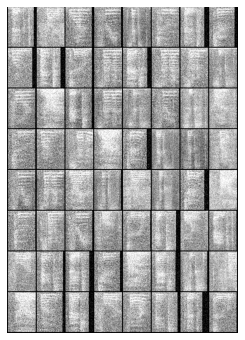

In [101]:
import tqdm
sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'} Another_Euler_Maruyama_sampler

## Generate samples using the specified sampler.
start = time.time()
samples = sampler(score_model = model, 
                marginal_prob_std = marginal_prob_std_fn,
                diffusion_coeff = diffusion_coeff_fn, 
                batch_size = 64,
                w= 4.0,
                num_steps = 300,
                z = None,
                cemb = cemblayer(classes),
                device=device)
end = time.time()

print(f"sampling time = {end-start:.2f}")
 
## Sample visualization.
#samples = samples.clamp(0.0, 1.0)
#%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

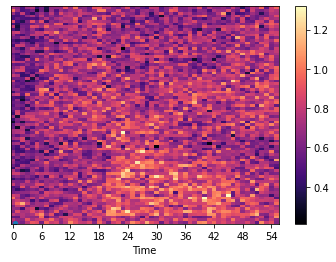

In [107]:
results = samples[1]
fig, ax = plt.subplots()
img = librosa.display.specshow(results.cpu().squeeze().numpy())
fig.colorbar(img, ax=ax)

a = inference_to_audio(results.to(torch.float32))
ipd.Audio(a, rate= 22050)

In [31]:
classes

tensor([8, 5, 1, 3, 6, 2, 8, 2, 1, 8, 2, 7, 8, 7, 7, 6, 4, 9, 8, 7, 6, 3, 6, 5,
        2, 1, 7, 9, 2, 6, 6, 5, 3, 7, 9, 6, 5, 6, 2, 5, 2, 7, 3, 4, 2, 8, 4, 8,
        4, 8, 8, 2, 9, 8, 6, 5, 9, 1, 8, 4, 4, 8, 8, 2], device='cuda:0')

## Noisy data 생성

In [ ]:
## Korean Speech
inference_data = torchaudio.load('kss_data/kss/4/4_5631.wav')[0]
inference_resample_audio = torchaudio.functional.resample(inference_data, orig_freq=44100, new_freq=22050)
inference_mel= mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) ## [1,80,128] 



In [ ]:
inference_resample_audio = torchaudio.functional.resample(dataset[1][0], orig_freq=48000, new_freq=22050)
inference_mel = mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) #[11025:32802+11025]

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(inference_mel[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(inference_mel[0])
ipd.Audio(a, rate= 22050)


In [ ]:
nosiy_data = q_sample(inference_mel, torch.tensor([40]))
fig, ax = plt.subplots()
img = librosa.display.specshow(nosiy_data[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(nosiy_data[0])
ipd.Audio(a, rate= 22050)

In [ ]:
inference_mel.shape

In [ ]:
torch.randn(1,80,507).chunk(2,2)[0].shape

In [ ]:
inference_mel.chunk(2, 2)[1].shape
## 향후에 전체 음성으로 해보기
## 완전 가우시안 노이즈가 아닌 노이즈가 낀 이미지를 Enhancement 하는 것
## 전체 음성으로 하려면 노이즈가 낀 이미지를 나눠야함. 그 후 각각의 분할마다 for문을 돌려서 enhancement 시키고 나중에 합쳐서 생성
## 추론에 시간 엄청 걸릴듯
## 하나의 샘플이면 괜찮을지도

In [ ]:

# Algorithm 2 (including returning all images)
@torch.no_grad()
def Enhancement_p_sample_loop(model, shape, image, timesteps):
    device = next(model.parameters()).device
    
    timesteps = timesteps 

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = image.to(device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs



In [ ]:
result = Enhancement_p_sample_loop(model, shape = (1,1,80,128), image = nosiy_data.unsqueeze(0), timesteps= 50)

In [ ]:

fig, ax = plt.subplots()
img = librosa.display.specshow(result[-1][0][0])
fig.colorbar(img, ax=ax)
a = inference_to_audio(torch.tensor(result[-1][0]))
ipd.Audio(a, rate= 22050)

In [ ]:
result[-1][0].shape

In [ ]:
a= inference_to_audio(torch.tensor(samples[-1][7], device= device))
ipd.Audio(a, rate= 22050)

# -------------------------------나중에 ModuleList 재 시도----------------------------------------

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=128,
    init_dim = 64,
    channels=1,
    dim_mults=(1, 2, 2, 4),
    attn_resolution = (4,8,16),
    resnet_block_groups= 32
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition = False,
        attn_resolution = (2,4,8),
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: init_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = init_dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(init_dim),
            nn.Linear(init_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        
        ds = 1
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
                        
            layer= [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                    ]
            
            if ds in attn_resolution:
                
                layer.append(Residual(PreNorm(dim_in, LinearAttention(dim_in))),)
            else:
                layer.append(
                            block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                )
                
            if not is_last:
                layer.append(
                            Downsample(dim_in,dim_out), 
                )
            else:
                layer.append(
                           nn.Conv2d(dim_in, dim_out,3, padding=1),    
                )
                
            ds *=2

            self.downs = nn.ModuleList(layer)
            print("fuking downs = ", self.downs)

        
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                    ]
                )
            )
            if ds in attn_resolution:
                self.ups.extend(
                    nn.ModuleList(
                        [
                            block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                            Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                            
                        ]
                    )
                )
            else:
                self.ups.extend(
                    nn.ModuleList(
                        [
                            block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        ]
                    )
                )
            
            if not is_last:
                self.ups.extend(
                nn.ModuleList(
                    [
                            Upsample(dim_out, dim_in),   
                    ]
                )
            )
            else:
                self.ups.extend(
                nn.ModuleList(
                    [
                            nn.Conv2d(dim_out, dim_in, 3, padding=1),    
                    ]
                )
            )
                
            ds /= 2
        
        #self.ups = nn.Sequential(self.ups)
        
        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(init_dim * 2, init_dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []
        
        for module in self.downs:
            print(module)
            x = module(x, t)
            h.append(x)


        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for module in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = module(x, t)


        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [ ]:
class SDE(abc.ABC):
    """SDE abstract class. Functions are designed for a mini-batch of inputs."""

    def __init__(self, N):
        """Construct an SDE.

        Args:
          N: number of discretization time steps.
        """
        super().__init__()
        self.N = N

    @property
    @abc.abstractmethod
    def T(self):
        """End time of the SDE."""
        pass

    @abc.abstractmethod
    def sde(self, x, t):
        pass

    @abc.abstractmethod
    def marginal_prob(self, x, t):
        """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, rng, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass

    @abc.abstractmethod
    def prior_logp(self, z):
        """Compute log-density of the prior distribution.

        Useful for computing the log-likelihood via probability flow ODE.

        Args:
          z: latent code
        Returns:
          log probability density
        """
        pass

    def discretize(self, x, t):
        """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

        Useful for reverse diffusion sampling and probabiliy flow sampling.
        Defaults to Euler-Maruyama discretization.

        Args:
          x: a JAX tensor.
          t: a JAX float representing the time step (from 0 to `self.T`)

        Returns:
          f, G
        """
        dt = 1 / self.N
        drift, diffusion = self.sde(x, t)
        f = drift * dt
        G = diffusion * jnp.sqrt(dt)
        return f, G

    def reverse(self, score_fn, probability_flow=False):
        """Create the reverse-time SDE/ODE.

        Args:
          score_fn: A time-dependent score-based model that takes x and t and returns the score.
          probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
        """
        N = self.N
        T = self.T
        sde_fn = self.sde
        discretize_fn = self.discretize

        # Build the class for reverse-time SDE.
        class RSDE(self.__class__):
            def __init__(self):
                self.N = N
                self.probability_flow = probability_flow

            @property
            def T(self):
                return T

            def sde(self, x, t):
                """Create the drift and diffusion functions for the reverse SDE/ODE."""
                drift, diffusion = sde_fn(x, t)
                score = score_fn(x, t)
                drift = drift - batch_mul(diffusion ** 2, score * (0.5 if self.probability_flow else 1.))
                # Set the diffusion function to zero for ODEs.
                diffusion = jnp.zeros_like(diffusion) if self.probability_flow else diffusion
                return drift, diffusion

            def discretize(self, x, t):
                """Create discretized iteration rules for the reverse diffusion sampler."""
                f, G = discretize_fn(x, t)
                rev_f = f - batch_mul(G ** 2, score_fn(x, t) * (0.5 if self.probability_flow else 1.))
                rev_G = jnp.zeros_like(G) if self.probability_flow else G
                return rev_f, rev_G

        return RSDE()


class VPSDE(SDE):
    def __init__(self, beta_min=0.1, beta_max=20, N=1000):
        """Construct a Variance Preserving SDE.

        Args:
          beta_min: value of beta(0)
          beta_max: value of beta(1)
          N: number of discretization steps
        """
    super().__init__(N)
    self.beta_0 = beta_min
    self.beta_1 = beta_max
    self.N = N
    self.discrete_betas = jnp.linspace(beta_min / N, beta_max / N, N)
    self.alphas = 1. - self.discrete_betas
    self.alphas_cumprod = jnp.cumprod(self.alphas, axis=0)
    self.sqrt_alphas_cumprod = jnp.sqrt(self.alphas_cumprod)
    self.sqrt_1m_alphas_cumprod = jnp.sqrt(1. - self.alphas_cumprod)

    @property
    def T(self):
        return 1

    def sde(self, x, t):
        beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
        drift = -0.5 * batch_mul(beta_t, x)
        diffusion = jnp.sqrt(beta_t)
        return drift, diffusion

    def marginal_prob(self, x, t):
        log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
        mean = batch_mul(jnp.exp(log_mean_coeff), x)
        std = jnp.sqrt(1 - jnp.exp(2. * log_mean_coeff))
        return mean, std

    def prior_sampling(self, rng, shape):
        return jax.random.normal(rng, shape)

    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logp_fn = lambda z: -N / 2. * jnp.log(2 * np.pi) - jnp.sum(z ** 2) / 2.
        return jax.vmap(logp_fn)(z)

    def discretize(self, x, t):
        """DDPM discretization."""
        timestep = (t * (self.N - 1) / self.T).astype(jnp.int32)
        beta = self.discrete_betas[timestep]
        alpha = self.alphas[timestep]
        sqrt_beta = jnp.sqrt(beta)
        f = batch_mul(jnp.sqrt(alpha), x) - x
        G = sqrt_beta
        return f, G